<a href="https://colab.research.google.com/github/WanjohiWanjohi/A-Btesting_SmartAd/blob/master/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of interactive ads on brand awareness
An exploration of the Brand Impact Optimiser (BIO) results on an experiment and control group


## Imports :Relevant packages used for the analysis are included in the notebook




In [27]:
#https://drive.google.com/file/d/1FVPOkNiQioJJ1A-NTy3YnoWYJZheCjPg/view?usp=sharing

import csv 
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [50]:

#function to load csv as dataframe

def load_csv_as_df(url):
    s = requests.get(url).content
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path)
    return df

#function to crete one row for response with 1 as yes and 0 as no
def create_value(row):
    if row['yes'] == 0 and row['no'] == 0:
        return 0
    elif row['yes'] == 1 and row['no'] == 0:
        return 1
    elif row['yes'] == 0 and row['no'] == 1:
      return 0



In [67]:
users = load_csv_as_df(url="https://drive.google.com/file/d/1FVPOkNiQioJJ1A-NTy3YnoWYJZheCjPg/view?usp=sharing")
users['response'] = users.apply(lambda row: create_value(row), axis=1)
#we want to use our test to confirm that the changes we make to our signup process will result in at least a 2% 

#get user counts in the control and xperiment group
user_counts = users['experiment'].value_counts()
n_a = user_counts.control
n_b = user_counts.exposed
ab_summary = users.pivot_table(values='response', index='experiment', aggfunc=np.sum)# add additional columns to the pivot table
#ab_summary['total'] = users.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = users.pivot_table(values='response', index='experiment')
ab_summary

,response,rate
experiment,,
control,264,0.064849
exposed,308,0.076885


# Descriptive Statistics Summary


In [ ]:
# looking at the distribution of the population
users['experiment'].describe()

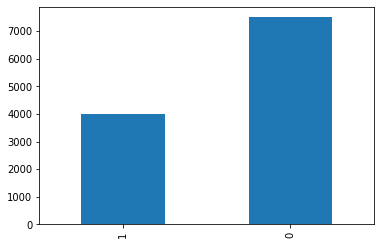

In [45]:
#lets look at the yes and no columns distribution as well as the experiment 
exp = users.experiment.value_counts().sort_values().plot.bar()
yes_dist = users.yes.value_counts().sort_values().plot.bar()
no_dist = users.no.value_counts().sort_values().plot.bar()
yes_dist.title = "Distribution of "